## Classificação de Intenções

Criando um classificador de intenções com dados do **multiwoz 2.2** usando tensorflow. O serviço escolhido foi o de trens, que possui os intents "find_train", "book_train" e "NONE" (intent não detectado ou não conhecido).

In [1]:
import pandas as pd
import tensorflow as tf
import re
import shutil
import string
from tensorflow.keras.layers import Dense, Embedding, TextVectorization, GlobalAveragePooling1D, Dropout
from tensorflow.keras import losses, Sequential

Carregando dataset com os dados das entradas de texto e os intents

In [5]:
textIntents = pd.read_csv('util/dadosTratados.csv', index_col=0)
textIntents.head()

,utterance,find_train,book_train,NONE
0,i need a train on tuesday out of kings lynn,1,0,0
1,I want to leave on Tuesday.,1,0,0
2,I'd like to leave after 9:30.,1,0,0
3,Looking for a train Tuesday leaving kings lynn...,1,0,0
4,"No, I'd like a train leaving after 09:30 depar...",1,0,0


Embaralhando o dataset

In [6]:
textIntents = textIntents.sample(frac=1)
textIntents.head(5)

,utterance,find_train,book_train,NONE
15299,"Yes, I think that's all I needed. Have a good ...",0,0,1
28257,Yes please!! I would also like to book a train...,1,0,0
14453,Yes I would like a guesthouse in the north.,0,0,1
1982,I'd like to leave after 10:00. I need you to b...,0,1,0
1485,I also need a train departing from cambridge g...,1,0,0


Iniciando vetorização dos textos (usando exemplos da documentação do tf como base)

In [7]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

In [9]:
vocab_size = 10000
sequence_length = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [10]:
def text2vector(text):
    return vectorize_layer(text)

In [11]:
textos_ex = textIntents['utterance'].tolist()
vectorize_layer.adapt(textos_ex)

Criando modelo

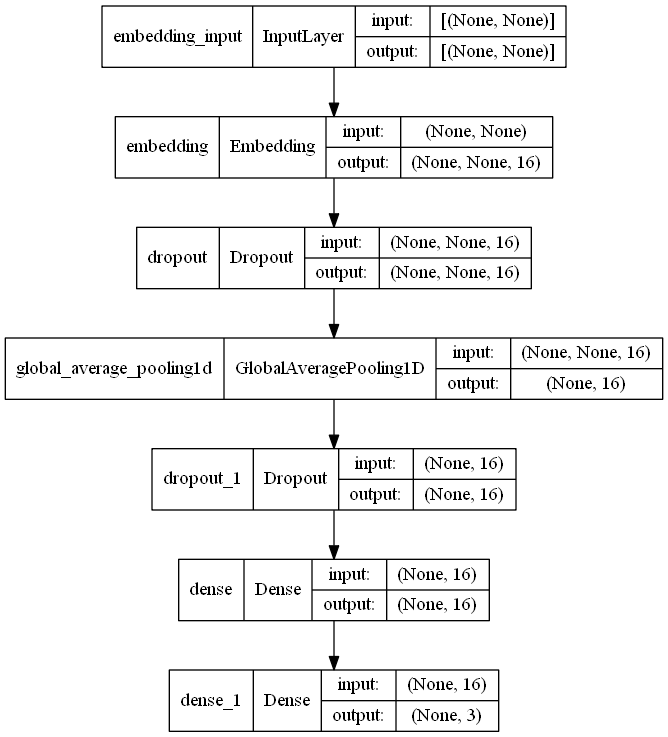

In [12]:
embedding_dim=16

model = Sequential([
  Embedding(vocab_size, embedding_dim, name="embedding"), Dropout(0.2),
  GlobalAveragePooling1D(), Dropout(0.2), Dense(16),
  Dense(3, activation='softmax')
])

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [33]:
texts = textIntents['utterance'].tolist()
X_train = tf.convert_to_tensor([text2vector(text) for text in texts])

In [35]:
Y_train = textIntents.loc[:, textIntents.columns != 'utterance']
Y_train = tf.convert_to_tensor(Y_train)

Treinamento do modelo

In [36]:
epochs = 30
batch_size = 60

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/30
453/453 [==============================] - 3s 5ms/step - loss: 0.8730 - accuracy: 0.6297 - val_loss: 0.6395 - val_accuracy: 0.7886
Epoch 2/30
453/453 [==============================] - 2s 4ms/step - loss: 0.5050 - accuracy: 0.8184 - val_loss: 0.4467 - val_accuracy: 0.8343
Epoch 3/30
453/453 [==============================] - 2s 4ms/step - loss: 0.3918 - accuracy: 0.8594 - val_loss: 0.3733 - val_accuracy: 0.8724
Epoch 4/30
453/453 [==============================] - 2s 4ms/step - loss: 0.3507 - accuracy: 0.8789 - val_loss: 0.3461 - val_accuracy: 0.8801
Epoch 5/30
453/453 [==============================] - 2s 4ms/step - loss: 0.3321 - accuracy: 0.8867 - val_loss: 0.3315 - val_accuracy: 0.8920
Epoch 6/30
453/453 [==============================] - 2s 4ms/step - loss: 0.3178 - accuracy: 0.8920 - val_loss: 0.3217 - val_accuracy: 0.8926
Epoch 7/30
453/453 [==============================] - 2s 4ms/step - loss: 0.3072 - accuracy: 0.8965 - val_loss: 0.3188 - val_accuracy: 0.8926
Epoch 

#### Possíveis melhorias:
- Adicionar mais camadas na rede
- Testar mais parâmetros
- Balancear a base de dados, frases sem intents tem um número maior de entradas

## Extração de Intenções